---

# AUC, BAC and regular accuracy

### Content

+ [1. Notebook description](#1.-Notebook-Description)
+ [2. Generate Data](#2.-Generate-Data)
+ [3. Näive Accuracy](#3.-Näive-Accuracy)
+ [4. Balanced Class Weights](#4.-Balanced-Class-Weights)
+ [5. Balanced Class Weights](#5.-Balanced-Accuracy-(Brodersen-2000)
+ [6. AUC score](#6.-AUC-Score)


---

# 1. Notebook Description

This notebook is used to generate some sample data and compare different accuracy scores.
It's mainly used for my thesis document

---

**Imports:**

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.random import sample_without_replacement
from sklearn.metrics import roc_curve, auc

from digits.metrics.cfm import Confusion

import numpy as np
from numpy.random import randn

import matplotlib.pyplot as plt
%matplotlib inline

---

# 2. Generate Data

We are looking at two unevenly balanced labels. Their ratio is set here.

In [4]:
ratio = 0.1

Let's create an array of 1000 labels with the above ratio.

In [5]:
n_samp = 10000
n_0 = int(n_samp*ratio)
n_1 = int(n_samp*(1 - ratio))
labels = np.hstack((
        np.zeros(n_0),
        np.zeros(n_1) + 1))

And then shuffle them:

In [6]:
labels = np.random.choice(labels, n_samp)

We also need 1000 completely random samples. Let's give them 20 features each.

In [7]:
samples = randn(n_samp, 20)

For some of the samples we add the label so they will carry information that can be classified.
The other samples are still completely random.

Assume we pick an `inf_ratio` of 20% or 0.2.
The highest prediction accuracy a classifier can get is 60%. For 80% of the samples we expect a draw and for 20% of the samples a correct classification with probability 1.0.

$$
P(C) = P(C|D) \cdot P(D) + P(C|\neg D) \cdot P(\neg D) \\
= 1.0 \cdot 0.2 + 0.5 \cdot 0.8 \\
= 0.6
$$

In [8]:
inf_ratio = 0.2
inf_index = int(inf_ratio*n_samp)
for feature in np.arange(samples.shape[1]):
    samples[:inf_index, feature] += labels[:inf_index]*2*randn() - 1

# 3. Näive Accuracy

A high simple accuracy can be achieved by simply labeling all samples as the predominant class.

Of course that is way too overconfident.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(samples, labels, stratify=labels)
svm = SVC(kernel='rbf', probability=True).fit(X_train, y_train)

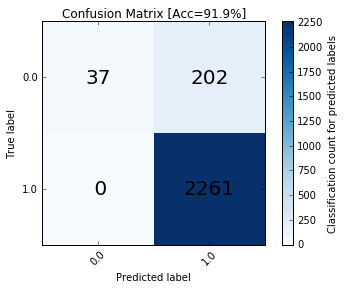

In [10]:
Confusion(svm, X_test, y_test, normalize=False).plot()

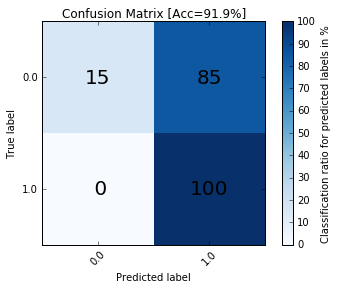

In [11]:
Confusion(svm, X_test, y_test, normalize=True).plot()

# 4. Balanced Class Weights

By telling the classifier to use higher weights for underrepresented labels we can slightly improve the situation.
But the plain accuracy is still way off the expected value.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(samples, labels, stratify=labels)
svm = SVC(kernel='rbf', class_weight='balanced').fit(X_train, y_train)

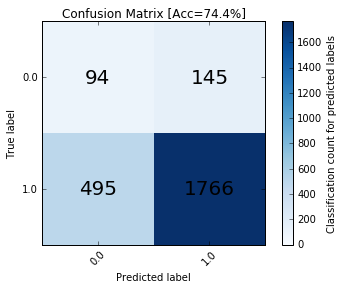

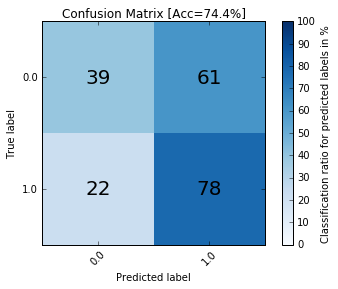

In [13]:
cfm = Confusion(svm, X_test, y_test, normalize=False)
cfm.plot()
Confusion(svm, X_test, y_test, normalize=True).plot()

# 5. Balanced Accuracy (Brodersen 2000)

$$
BAC = \frac{1}{2}(PPV + NPV) \\
= \frac{1}{2}\left(\frac{TP}{TP+FP} + \frac{TN}{TN+FN}\right)\\
$$

The actual values are stored in the cfm.matrix array:

In [14]:
cfm.matrix

array([[  94,  145],
       [ 495, 1766]])

In [15]:
bac = 0.5 * ( cfm.matrix[0,0] / cfm.matrix[0,].sum() +
              cfm.matrix[1,1] / cfm.matrix[1,].sum())
print(bac)

0.587187881098


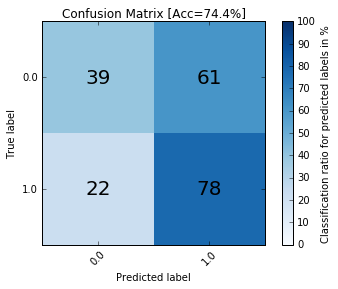

In [16]:
Confusion(svm, X_test, y_test, normalize=True).plot()

# 6. AUC Score

In [17]:
X_train, X_test, y_train, y_test = train_test_split(samples, labels, stratify=labels)
svm = SVC(kernel='rbf', probability=True).fit(X_train, y_train)

In [18]:
y_prob = svm.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob, drop_intermediate=False)
roc_auc = auc(fpr, tpr)

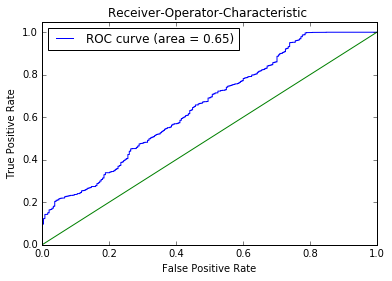

In [19]:
plt.plot(fpr, tpr, label='ROC curve (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver-Operator-Characteristic ')
plt.legend(loc="upper left")
plt.show()

---